In [1]:
from perses.analysis.analysis import Analysis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymbar
%matplotlib inline
import os
import itertools
from tqdm import tqdm_notebook
import pandas as pd
import tqdm
import warnings
warnings.filterwarnings('ignore')
from simtk.openmm import unit
from openmmtools.constants import kB
KT_KCALMOL = kB * 300 * unit.kelvin / unit.kilocalories_per_mole
import pandas as pd
import pickle

In [2]:
def analyze(forward_accumulated, reverse_accumulated): 
    # Compute dg, ddg
    dg, ddg = pymbar.bar.BAR(forward_accumulated, reverse_accumulated)
    return dg, ddg

def analyze_bootstrap(d_works):
    d_dgs_phase = {}
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    d_dgs_phase['complex'] = (complex_dg, complex_ddg)
    d_dgs_phase['apo'] = (apo_dg, apo_ddg)
    
    binding_dg = complex_dg - apo_dg
#     binding_ddg = (apo_ddg**2 + complex_ddg**2)**0.5
    return d_dgs_phase, binding_dg
    
def plot(forward_work, reverse_work, dg, ddg, dir_num, phase, output_dir, title):
#     # Substract offset
#     print("subtracting offset")
    forward_work_offset = []
    for cycle in forward_work:
        forward_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    forward_work_offset = np.array(forward_work_offset)

    reverse_work_offset = []
    for cycle in reverse_work:
        reverse_work_offset.append(np.array([val - cycle[0] for val in cycle[1:]]))
    reverse_work_offset = np.array(reverse_work_offset)

    # Plot work trajectories
    print("plotting work trajs")
    for cycle in forward_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = cycle
        plt.plot(x, y, color=sns.color_palette()[0])
    for cycle in reverse_work_offset:
        x = [(i+1)*4e-4 for i in range(len(list(cycle)))]
        y = -cycle
        plt.plot(x, y, color=sns.color_palette()[1])
    plt.xlabel("$t_{neq}$ (ns)")
    plt.ylabel("work (kT)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_traj.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_traj.png')}")
    plt.clf()
    
    # Plot work distributions
    print("plotting work distrib")
    accumulated_forward = [cycle[-1] for cycle in forward_work_offset]
    accumulated_reverse = [-cycle[-1] for cycle in reverse_work_offset]
    sns.distplot(accumulated_forward)
    sns.distplot(accumulated_reverse)
    plt.axvline(dg)
    plt.axvline(dg + ddg, linestyle='dashed')
    plt.axvline(dg - ddg, linestyle='dashed')
    plt.xlabel("work (kT)")
    plt.ylabel("p(w)")
    plt.title(f"{title} {phase}")
    plt.savefig(os.path.join(output_dir, f"{dir_num}_{phase}_work_dist.png"), dpi=500)
    print(f"saved to: {os.path.join(output_dir, f'{dir_num}_{phase}_work_dist.png')}")
    plt.clf()

    return accumulated_forward
    

## 15/341

In [8]:
# Load data into dicts and plot 
titles = ["N501Y"]
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
d_input = {}
dir_num = 15
forward = 341
for i in tqdm_notebook([forward]):
    print(f"dir: {i}")
    d_works = {"complex": {}, "apo":{}}
    d_combined_works = {"complex": {}, "apo":{}}
    for phase in phases:
        for direction in directions:
            all_arrays = []
            for j in range(100):
                path = f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{i}/{i}_{phase}_{j}_{direction}.npy"
                try:
                    if os.path.exists(path):
                        with open(path, 'rb') as f:
                            array = np.load(f)
                            if not np.isnan(np.sum(array)):
                                all_arrays.append(array)
                except:
                    continue
            print(len(all_arrays))
            if all_arrays:
                combined = np.concatenate(all_arrays)
                accumulated = np.array([cycle[-1] - cycle[0] for cycle in combined])
#                 combined = np.array([cycle[0::100] for cycle in combined])
                print(f"about to save: {phase} {direction}")
                d_combined_works[phase][direction] = combined
                d_works[phase][direction] = accumulated

    d_input[i] = d_works
    
    # Plot
    complex_dg, complex_ddg = analyze(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_dg, apo_ddg = analyze(d_works['apo']['forward'], d_works['apo']['reverse'])
    plot(d_combined_works['complex']['forward'], d_combined_works['complex']['reverse'], complex_dg, complex_ddg, i, 'complex', os.path.dirname(path), titles[i-forward])
    plot(d_combined_works['apo']['forward'], d_combined_works['apo']['reverse'], apo_dg, apo_ddg, i, 'apo', os.path.dirname(path), titles[i-forward])
    print("binding DDG: ", complex_dg*KT_KCALMOL - apo_dg*KT_KCALMOL, " (", ((apo_ddg**2 + complex_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_dg*KT_KCALMOL, " (", complex_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_dg*KT_KCALMOL, " (", apo_ddg*KT_KCALMOL,")")
    
    complex_upper_dg, complex_upper_ddg, complex_lower_dg, complex_lower_ddg = bound_with_exp(d_works['complex']['forward'], d_works['complex']['reverse'])
    apo_upper_dg, apo_upper_ddg, apo_lower_dg, apo_lower_ddg = bound_with_exp(d_works['apo']['forward'], d_works['apo']['reverse'])
    print("binding DDG (upper): ", complex_upper_dg*KT_KCALMOL - apo_upper_dg*KT_KCALMOL, " (", ((apo_upper_ddg**2 + complex_upper_ddg**2)**0.5)*KT_KCALMOL, ")")
    print("complex DG: ", complex_upper_dg*KT_KCALMOL, " (", complex_upper_ddg*KT_KCALMOL,")")
    print("apo DG: ", apo_upper_dg*KT_KCALMOL, " (", apo_upper_ddg*KT_KCALMOL,")")
    print("binding DDG (lower): ", complex_lower_dg*-KT_KCALMOL - apo_lower_dg*-KT_KCALMOL, " (", ((apo_lower_ddg**2 + complex_lower_ddg**2)**0.5)*-KT_KCALMOL, ")")
    print("complex DG: ", complex_lower_dg*-KT_KCALMOL, " (", complex_lower_ddg*-KT_KCALMOL,")")
    print("apo DG: ", apo_lower_dg*-KT_KCALMOL, " (", apo_lower_ddg*-KT_KCALMOL,")")
    

  0%|          | 0/1 [00:00<?, ?it/s]

dir: 341
100
about to save: complex forward
100
about to save: complex reverse
100
about to save: apo forward
100
about to save: apo reverse
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/341/341_complex_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/341/341_complex_work_dist.png
plotting work trajs
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/341/341_apo_work_traj.png
plotting work distrib
saved to: /data/chodera/zhangi/perses_benchmark/neq/15/341/341_apo_work_dist.png
binding DDG:  2.706266576169895  ( 0.5352535133076558 )
complex DG:  69.85357873346668  ( 0.5317243142342116 )
apo DG:  67.14731215729678  ( 0.061364298744027934 )
binding DDG (upper):  4.636905818004593  ( 0.45860184158665307 )
complex DG:  71.66020744835487  ( 0.42053583533705874 )
apo DG:  67.02330163035028  ( 0.18293512594368508 )
binding DDG (lower):  0.7407111099056038  ( -0.501645861658641 )
complex DG:  67.94358011632681  ( -0.4780

<Figure size 432x288 with 0 Axes>

In [9]:
apo_dg

112.63279699830298

In [10]:
complex_dg

117.1722843449147

(array([ 4., 11., 15.,  8., 13., 22., 17.,  5.,  3.,  2.]),
 array([ 97.01431174,  99.14808691, 101.28186208, 103.41563724,
        105.54941241, 107.68318757, 109.81696274, 111.95073791,
        114.08451307, 116.21828824, 118.35206341]),
 <BarContainer object of 10 artists>)

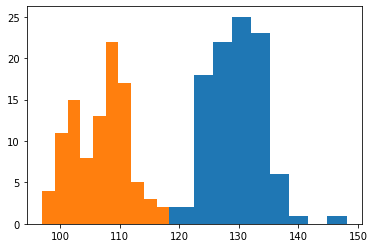

In [11]:
plt.hist(d_works['complex']['forward'])
plt.hist(d_works['complex']['reverse']*-1)

(array([ 2.,  4.,  8., 11., 18., 18., 24., 12.,  2.,  1.]),
 array([106.7809979 , 107.69201991, 108.60304191, 109.51406392,
        110.42508593, 111.33610793, 112.24712994, 113.15815195,
        114.06917396, 114.98019596, 115.89121797]),
 <BarContainer object of 10 artists>)

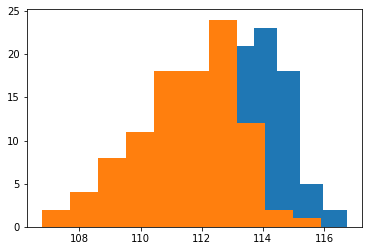

In [12]:
plt.hist(d_works['apo']['forward'])
plt.hist(d_works['apo']['reverse']*-1)

In [13]:
# Bootstrap works
N_bootstraps = 10000
phases = ['complex', 'apo']
directions = ['forward', 'reverse']
dgs_phase = {}
ddgs = {}
for i in [forward]:
    dgs_phase_all = []
    ddgs_all = []
    for _ in tqdm_notebook(range(N_bootstraps)):
        # Initialize data structure for works
        d_works = {"complex": {"forward":{}, "reverse":{}}, "apo":{"forward":{}, "reverse":{}}}

        # Save subsampled works
        for phase in phases:
            for direction in directions:
                work_array = np.array(d_input[i][phase][direction])
                num_samples = work_array.shape[0]
                subsample_indices = np.random.choice(range(num_samples), num_samples)
                d_works[phase][direction] = work_array[subsample_indices]
        d_dgs_phase, binding_dg = analyze_bootstrap(d_works)
        dgs_phase_all.append(d_dgs_phase)
        ddgs_all.append(binding_dg)
    dgs_phase[i] = dgs_phase_all
    ddgs[i] = ddgs_all
    
    


  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
forward_ddg = np.mean(ddgs[forward])
forward_ci = np.percentile(ddgs[forward], 2.5), np.percentile(ddgs[forward], 97.5)
# reverse_ddg = np.mean(ddgs[reverse])
# reverse_ci = np.percentile(ddgs[reverse], 2.5), np.percentile(ddgs[reverse], 97.5)
# negative_reverse_ci = sorted(np.array(reverse_ci)*-1)
# discrepancy = tuple(np.array(forward_ci) - np.array(negative_reverse_ci))
# output_kt = [forward_ddg, forward_ci, reverse_ddg, reverse_ci, discrepancy]
# output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL]), round(reverse_ddg*KT_KCALMOL, 2), tuple([round(val, 2) for val in np.array(reverse_ci)*KT_KCALMOL]), tuple([round(val, 2) for val in np.array(discrepancy)*KT_KCALMOL])]

output_kcalmol = [round(forward_ddg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(forward_ci)*KT_KCALMOL])]



In [15]:
output_kcalmol

[2.85, (1.81, 4.31)]

In [16]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "wb") as f:
    pickle.dump(dgs_phase, f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "wb") as f:
    pickle.dump(ddgs, f)

In [17]:
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/dgs_phase.pickle", "rb") as f:
    dgs_phase = pickle.load(f)
with open(f"/data/chodera/zhangi/perses_benchmark/neq/{dir_num}/{forward}/ddgs.pickle", "rb") as f:
    ddgs = pickle.load(f)

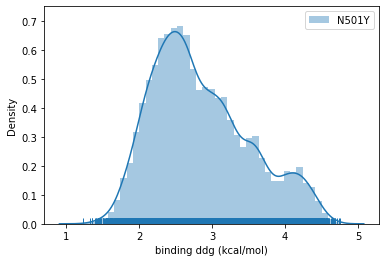

In [18]:
# Plot ddgs
sns.distplot(np.array(ddgs[forward])*KT_KCALMOL, rug=True, label=titles[0])
# sns.distplot(np.array(ddgs[reverse])*-KT_KCALMOL, rug=True, label=f"-({titles[1]})")
plt.xlabel("binding ddg (kcal/mol)")
plt.legend()

In [19]:
# Get the std error
np.std(np.array(ddgs[forward])*KT_KCALMOL)

0.6712113076649306

In [20]:
apo_dg = np.mean([d['apo'][0] for d in dgs_phase[forward]])
apo_ci = np.percentile([d['apo'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['apo'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_apo = [round(apo_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(apo_ci)*KT_KCALMOL])]

complex_dg = np.mean([d['complex'][0] for d in dgs_phase[forward]])
complex_ci = np.percentile([d['complex'][0] for d in dgs_phase[forward]], 2.5), np.percentile([d['complex'][0] for d in dgs_phase[forward]], 97.5)
output_kcalmol_complex = [round(complex_dg*KT_KCALMOL, 2), tuple([round(val, 2)for val in np.array(complex_ci)*KT_KCALMOL])]


In [21]:
output_kcalmol_apo

[67.15, (67.02, 67.27)]

In [22]:
output_kcalmol_complex

[70.0, (68.98, 71.45)]

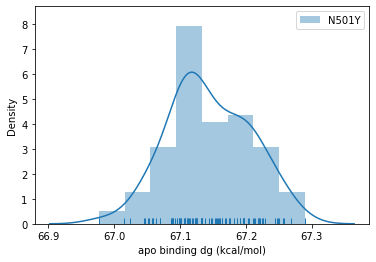

In [23]:
# Plot dgs
sns.distplot(np.array([dgs_phase[forward][i]['apo'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("apo binding dg (kcal/mol)")
plt.legend()

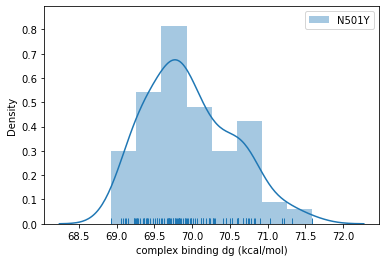

In [24]:
# Plot dgs
sns.distplot(np.array([dgs_phase[forward][i]['complex'][0]*KT_KCALMOL for i in range(100)]), rug=True, label=titles[0])
plt.xlabel("complex binding dg (kcal/mol)")
plt.legend()